In [26]:
from HeartbeatDetector import *

# For computations
import numpy as np
import cv2
import scipy.signal as scsig

%load_ext autoreload
%autoreload 2

# For plotting
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# For file management
import os

import timeit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
video_path = (
    "../data/EchoNet-Dynamic/Videos"
)

videos = {
    # path: [mitral pre-launches]
    # Does OK but hard to see from covariance matrices
    "0XFE6E32991136338": np.array([17, 47, 77, 106]),
    # Does poorly - but the heartbeat is irregular
    # And the way we extracted these recurrences relied
    # on the assumption that the heartbeat is regular
    # May still be extractable by more sophisticated
    # post-processing methods that do not rely on regularity
    "0XF072F7A9791B060": np.array([24, 56, 100]),
    # Does well, and it is very clear that it would do well,
    # from the covariance matrices
    "0XF70A3F712E03D87": np.array([22, 66, 110]),
    # Does well
    "0XF60BBEC9C303C98": np.array([19, 67, 114, 162]),
    # Low quality video, does well
    "0XF46CF63A2A1FA90": np.array([25, 79, 134, 188])
}

In [23]:
def get_results(path: str, *, nonparanormal: bool):
    print(f"Loading video {path}")
    heartbeater = HeartbeatDetector(os.path.join(
        video_path,
        f"{path}.avi"
    ))
    heartbeater.unbend()
    Psis = heartbeater.get_graphs(nonparanormal=nonparanormal)

    mats = {0: Psis["frames"].copy()}
    sparsities = {0: 0.2}
    shrunks = draw(
        mats,
        sparsities,
        suptitle="Precision Matrices",
        ax_names={0: f"{sparsities[0]:.0%} Frames"}
    )
    plt.show()

    verti_diag = np.triu(shrunks[0]).reshape(-1)[:-1].reshape(
        shrunks[0].shape[0]-1,
        shrunks[0].shape[0]+1
    )
    verti_diag = 0*verti_diag +  verti_diag.mean(keepdims=True, axis=0)

    fig, ax = plt.subplots(figsize=(4, 4))

    min_time = 10
    smoothed_verti_diag = cv2.GaussianBlur(
        verti_diag[0],
        ksize=(5, 5),
        sigmaX=5
    )
    ax.plot(
        np.arange(verti_diag[0].shape[0]),
        smoothed_verti_diag
    )
    peaks = [0] + [
        peak for peak in
        scsig.find_peaks_cwt(
            smoothed_verti_diag[:, 0],
            widths=10
        )
        if peak > min_time
    ]
    for peak in peaks:
        ax.axvline(peak, color="red")
    ax.set_title("Gaps between repetition")
    ax.set_xlim(0, verti_diag[0].shape[0])

    # Sometimes a peak can occur after the end of the video
    # So we want to prune it out
    preds = videos[path][0] + peaks
    preds = preds[preds < verti_diag[0].shape[0]]

    print(f"{peaks=}")
    print(f"Predicted Mitral Valve Open @ {preds}")
    print(f"True Mitral Valve Open @ {videos[path]}")

    # Video 1 is the only one with substantial error,
    # but if you look at it you'll see that the heart does a weird
    # almost-opening-but-not-quite of the mitral valve at the predicted
    # value!
    plt.show()

# Experiment 1: GmGM without Nonparanormal

Loading video 0XFE6E32991136338


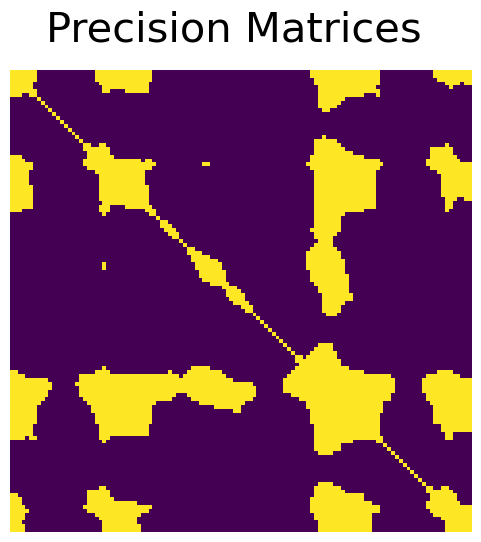

peaks=[0, 31, 60, 87, 119]
Predicted Mitral Valve Open @ [ 17  48  77 104]
True Mitral Valve Open @ [ 17  47  77 106]


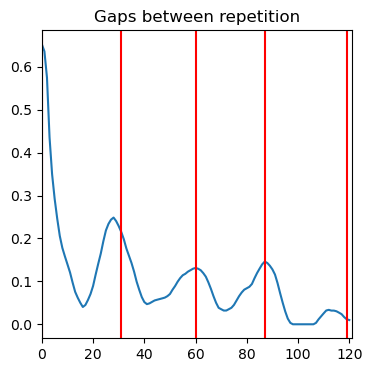

Loading video 0XF072F7A9791B060


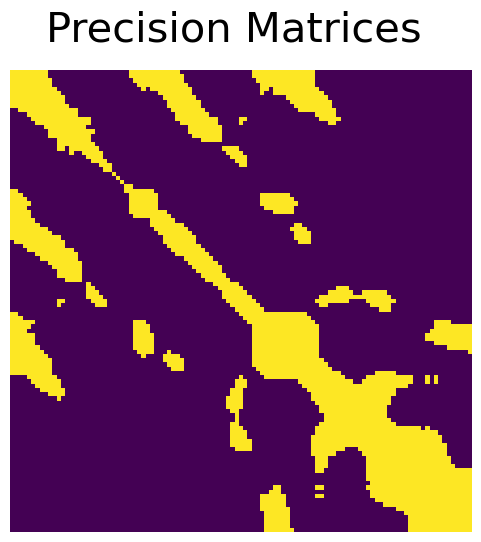

peaks=[0, 35, 65]
Predicted Mitral Valve Open @ [24 59 89]
True Mitral Valve Open @ [ 24  56 100]


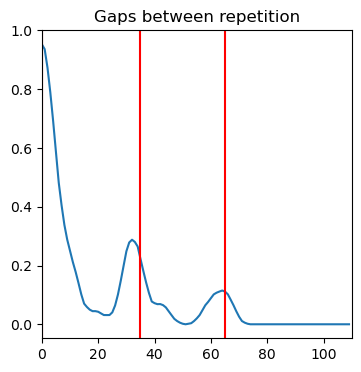

Loading video 0XF70A3F712E03D87


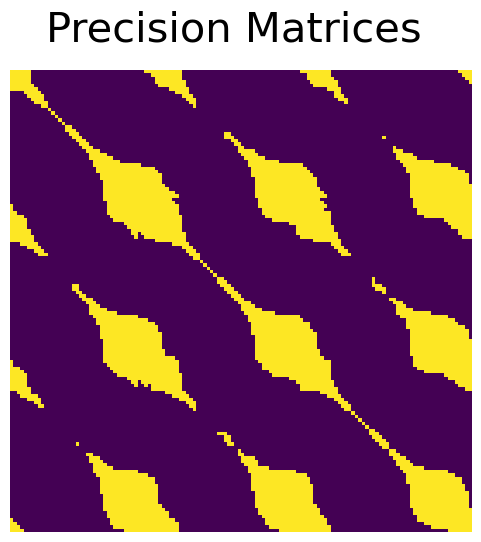

peaks=[0, 45, 90]
Predicted Mitral Valve Open @ [ 22  67 112]
True Mitral Valve Open @ [ 22  66 110]


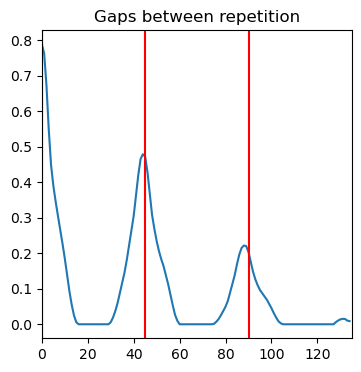

Loading video 0XF60BBEC9C303C98


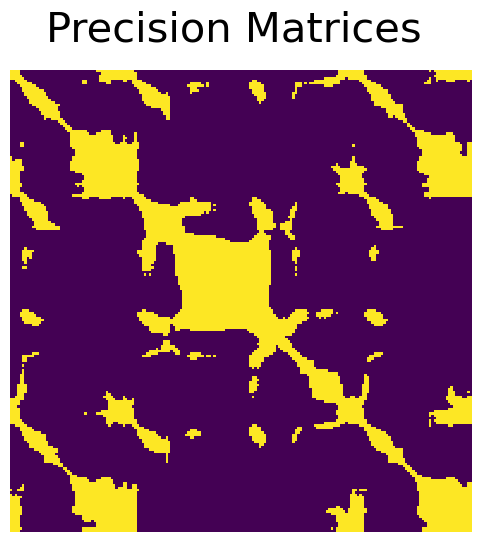

peaks=[0, 48, 96, 143, 185]
Predicted Mitral Valve Open @ [ 19  67 115 162]
True Mitral Valve Open @ [ 19  67 114 162]


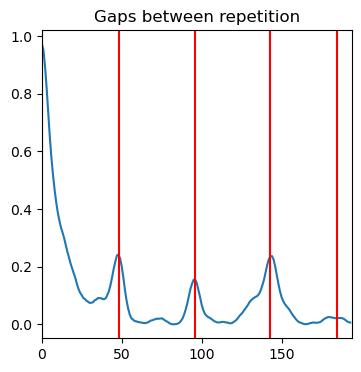

Loading video 0XF46CF63A2A1FA90


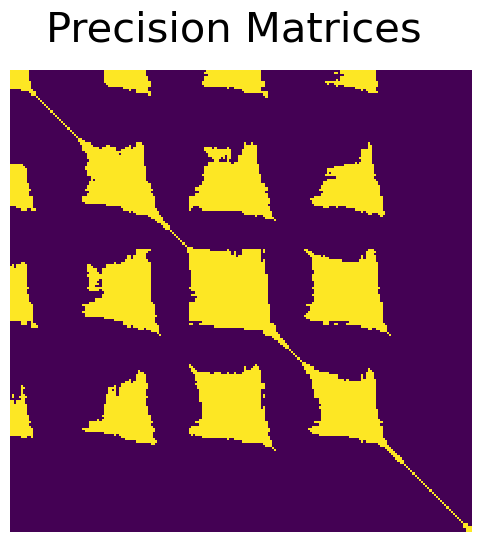

peaks=[0, 54, 106, 160]
Predicted Mitral Valve Open @ [ 25  79 131 185]
True Mitral Valve Open @ [ 25  79 134 188]


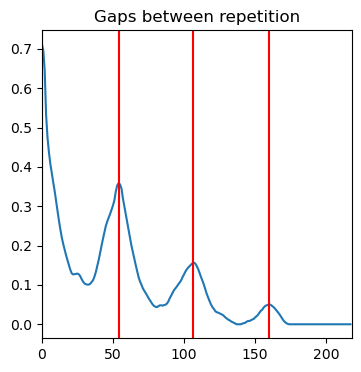

In [24]:
for path in videos.keys():
    get_results(path, nonparanormal=False)

# Experiment 2: GmGM With Nonparanormal

Loading video 0XFE6E32991136338


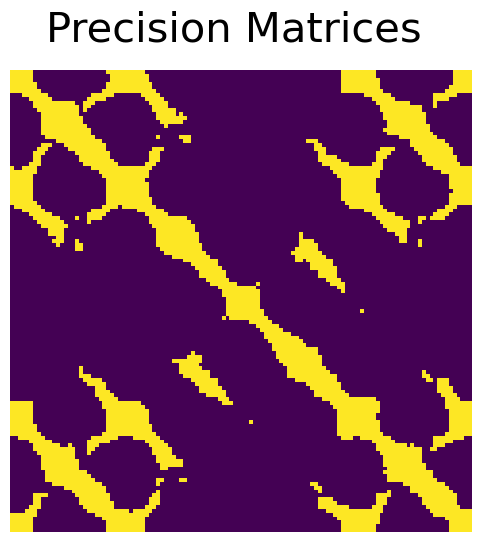

peaks=[0, 31, 60, 89]
Predicted Mitral Valve Open @ [ 17  48  77 106]
True Mitral Valve Open @ [ 17  47  77 106]


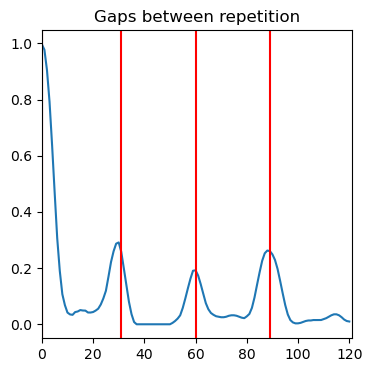

Loading video 0XF072F7A9791B060


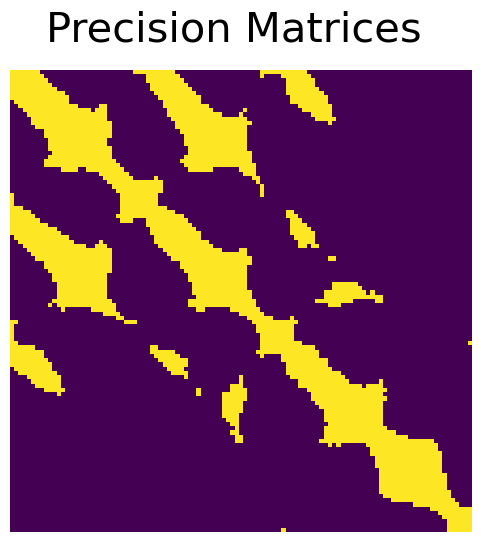

peaks=[0, 34, 67]
Predicted Mitral Valve Open @ [24 58 91]
True Mitral Valve Open @ [ 24  56 100]


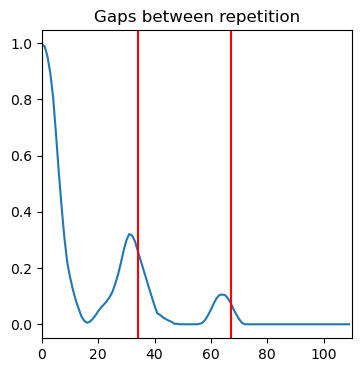

Loading video 0XF70A3F712E03D87


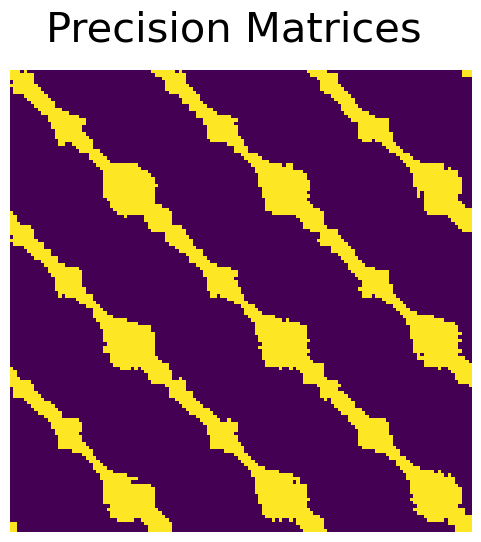

peaks=[0, 45, 90]
Predicted Mitral Valve Open @ [ 22  67 112]
True Mitral Valve Open @ [ 22  66 110]


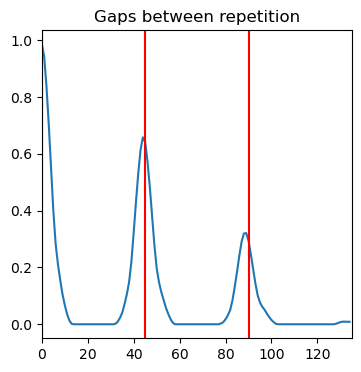

Loading video 0XF60BBEC9C303C98


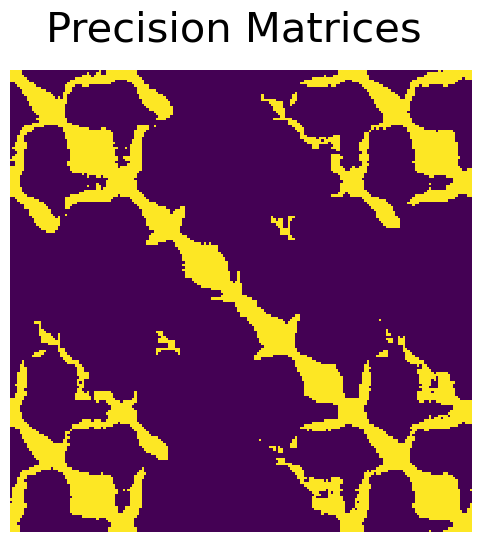

peaks=[0, 47, 97, 143, 184]
Predicted Mitral Valve Open @ [ 19  66 116 162]
True Mitral Valve Open @ [ 19  67 114 162]


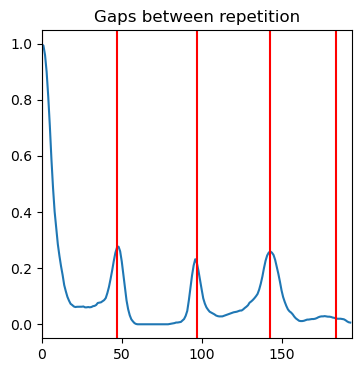

Loading video 0XF46CF63A2A1FA90


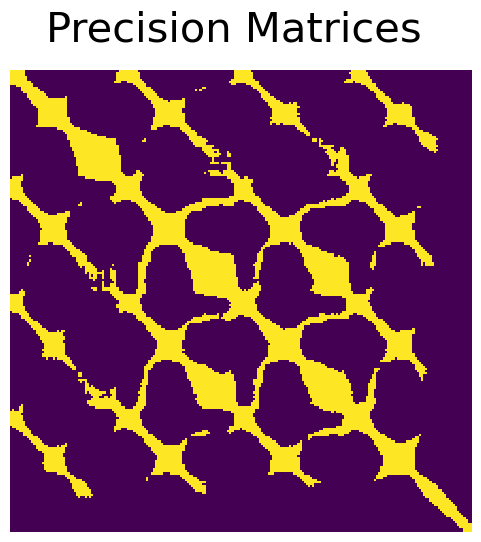

peaks=[0, 55, 109, 163]
Predicted Mitral Valve Open @ [ 25  80 134 188]
True Mitral Valve Open @ [ 25  79 134 188]


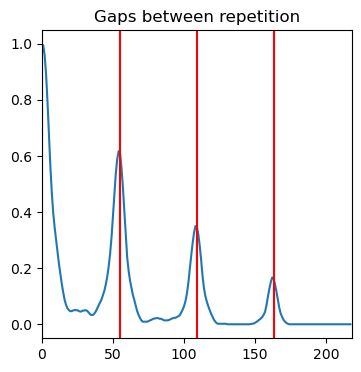

In [25]:
for path in videos.keys():
    get_results(path, nonparanormal=True)

# Experiment 3: Runtimes

In [36]:
def get_runtimes(path: str, *, nonparanormal: bool, teralasso: bool) -> float:
    print(f"Timing Video {path}")
    heartbeater = HeartbeatDetector(os.path.join(
        video_path,
        f"{path}.avi"
    ))
    heartbeater.unbend()
    return np.mean(timeit.repeat(lambda: heartbeater.get_graphs(
        nonparanormal=nonparanormal,
        teralasso=teralasso
    ), number=1, repeat=10))

## Experiment 3a: GmGM Runtime

In [37]:
runtime = 0
for path in videos.keys():
    runtime += get_runtimes(path, nonparanormal=False, teralasso=False)
runtime / len(videos.keys())

Timing Video 0XFE6E32991136338
Timing Video 0XF072F7A9791B060
Timing Video 0XF70A3F712E03D87
Timing Video 0XF60BBEC9C303C98
Timing Video 0XF46CF63A2A1FA90


0.06721988256002079

In [38]:
runtime = 0
for path in videos.keys():
    runtime += get_runtimes(path, nonparanormal=True, teralasso=False)
runtime / len(videos.keys())

Timing Video 0XFE6E32991136338
Timing Video 0XF072F7A9791B060
Timing Video 0XF70A3F712E03D87
Timing Video 0XF60BBEC9C303C98
Timing Video 0XF46CF63A2A1FA90


0.32790695916060936

## Experiment 3b: TeraLasso Runtime

In [39]:
runtime = 0
for path in videos.keys():
    runtime += get_runtimes(path, nonparanormal=False, teralasso=True)
runtime / len(videos.keys())

Timing Video 0XFE6E32991136338
Timing Video 0XF072F7A9791B060
Timing Video 0XF70A3F712E03D87
Timing Video 0XF60BBEC9C303C98
Timing Video 0XF46CF63A2A1FA90


40.422290324900686

In [41]:
runtime = 0
for path in videos.keys():
    runtime += get_runtimes(path, nonparanormal=True, teralasso=True)
runtime / len(videos.keys())

Timing Video 0XFE6E32991136338
Timing Video 0XF072F7A9791B060
Timing Video 0XF70A3F712E03D87
Timing Video 0XF60BBEC9C303C98
Timing Video 0XF46CF63A2A1FA90


11.785662671659665

# Exploratory Analysis

In [3]:
path = list(videos.keys())[2]
print(f"Loading video {path}")
heartbeater = HeartbeatDetector(os.path.join(
    video_path,
    f"{path}.avi"
))

Loading video 0XF70A3F712E03D87


In [9]:
heartbeater.unbend()
Psis = heartbeater.get_graphs(nonparanormal=True)

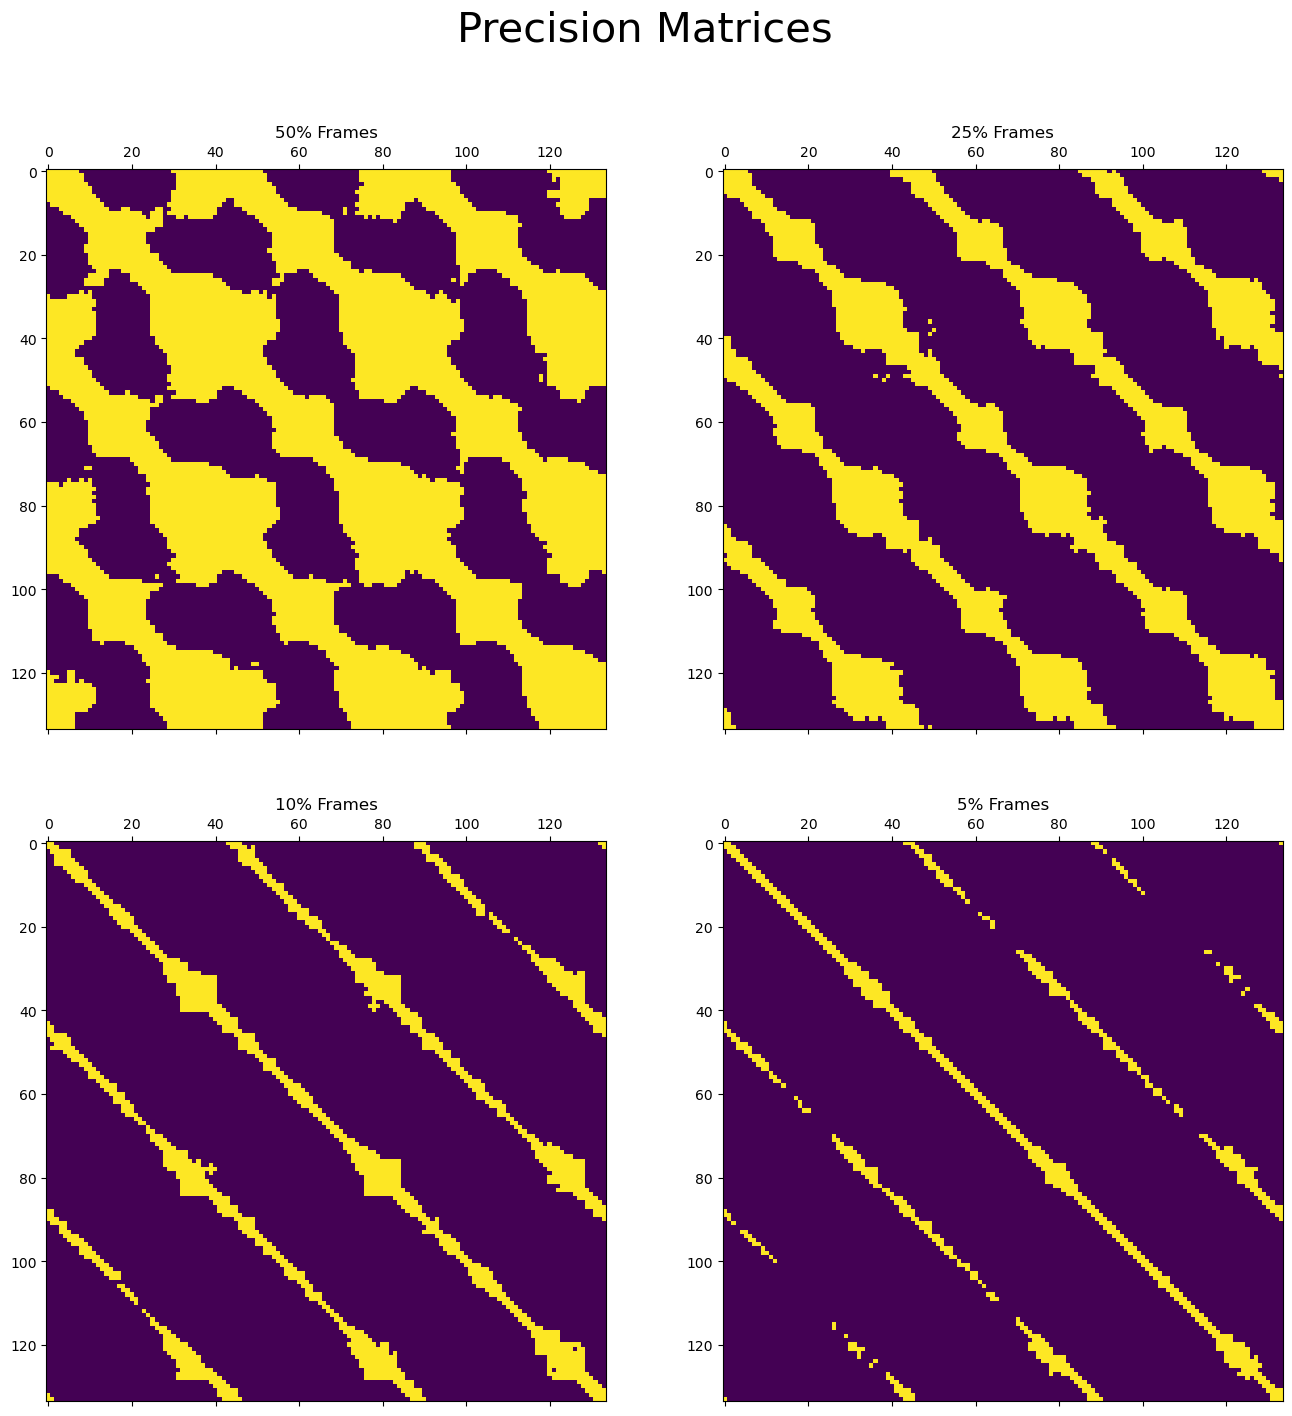

In [10]:
mats = {
    i: Psis["frames"].copy()
    for i in range(4)
}
sparsities = {
    0: 0.5,
    1: 0.25,
    2: 0.1,
    3: 0.05
}
shrunks = draw(
    mats,
    sparsities,
    suptitle="Precision Matrices",
    ax_names={
        i: f"{sparsities[i]:.0%} Frames"
        for i in range(4)
    }
)
plt.show()

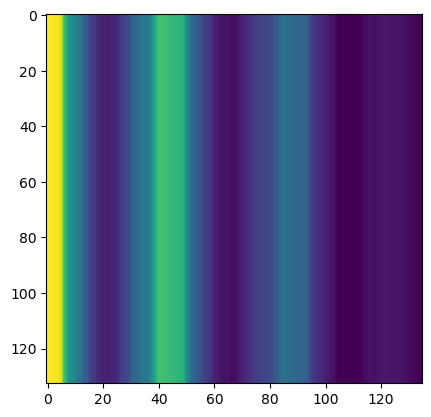

In [11]:
verti_diag = np.triu(shrunks[0]).reshape(-1)[:-1].reshape(
    shrunks[0].shape[0]-1,
    shrunks[0].shape[0]+1
)
verti_diag = 0*verti_diag +  verti_diag.mean(keepdims=True, axis=0)
plt.imshow(verti_diag)
plt.show()

peaks=[0, 44, 88, 126]
Predicted Mitral Valve Open @ [ 22  66 110]
True Mitral Valve Open @ [ 22  66 110]


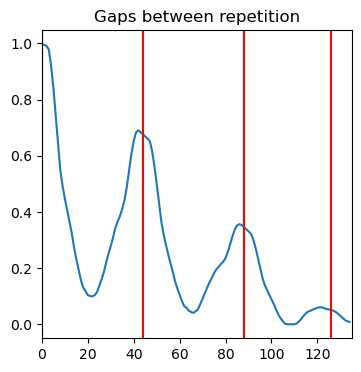

In [13]:
fig, ax = plt.subplots(figsize=(4, 4))

min_time = 10
smoothed_verti_diag = cv2.GaussianBlur(
    verti_diag[0],
    ksize=(5, 5),
    sigmaX=5
)
ax.plot(
    np.arange(verti_diag[0].shape[0]),
    smoothed_verti_diag
)
peaks = [0] + [
    peak for peak in
    scsig.find_peaks_cwt(
        smoothed_verti_diag[:, 0],
        widths=10
    )
    if peak > min_time
]
for peak in peaks:
    ax.axvline(peak, color="red")
ax.set_title("Gaps between repetition")
ax.set_xlim(0, verti_diag[0].shape[0])

# Sometimes a peak can occur after the end of the video
# So we want to prune it out
preds = videos[path][0] + peaks
preds = preds[preds < verti_diag[0].shape[0]]

print(f"{peaks=}")
print(f"Predicted Mitral Valve Open @ {preds}")
print(f"True Mitral Valve Open @ {videos[path]}")

# Video 1 is the only one with substantial error,
# but if you look at it you'll see that the heart does a weird
# almost-opening-but-not-quite of the mitral valve at the predicted
# value!
plt.show()

In [ ]:
# Run this line to see the video
display(HTML(heartbeater.plot_video().to_html5_video()))
plt.close()